In [ ]:
# 모듈 호출
import os
import sys
import glob
import shutil
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

### 데이터가져오기

In [ ]:
img_size = 224

In [ ]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        rotation_range=40,      # 40도까지 회전
        width_shift_range=0.2,  # 20%까지 좌우 이동
        height_shift_range=0.2, # 20%까지 상하 이동
        shear_range=0.2,        # 20%까지 기울임
        zoom_range=0.2,         # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './train_10',
    batch_size=50,      
    class_mode='categorical', 
    target_size=(224, 224)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './valid_10',
    batch_size=20,      
    class_mode='categorical', 
    target_size=(224, 224))

Found 10529 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './test_10',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(224, 224),
    shuffle=False)

Found 500 images belonging to 10 classes.


In [ ]:
print(train_generator.class_indices)

{'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}


In [ ]:
print(valid_generator.class_indices)

{'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}


In [ ]:
print(test_generator.class_indices)

{'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}


### 모델 학습하기

#### ZFNet 모델

##### [참고 git address] https://github.com/Bao-Jiarong/ZFNet

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/AI_service_develop/loader.py')
import loader
sys.path.append('/content/drive/MyDrive/ColabNotebooks/AI_service_develop/zfnet.py')
import zfnet

In [ ]:
# 모델 생성
model = zfnet.ZFNet((224,224,3), classes=10, filters=8)

In [ ]:
model.summary()

Model: "zf_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block (Block)               (None, 54, 54, 24)        3552      
                                                                 
 block_1 (Block)             (None, 13, 13, 64)        38464     
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 block_2 (Block)             (None, 6, 6, 128)         295040    
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 2304)              10619

In [ ]:
# 모델 환경설정
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_name = './model/ZFNet_01_{epoch:02d}-{val_loss:.4f}.h5'

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = model_name,
                                                 save_weights_only=True,
                                                 verbose=0, 
                                                 save_freq="epoch")

In [ ]:
# parameter 정의
epochs = 20
lr_rate = 0.0001
batch_size = 32

history = model.fit(train_generator,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=valid_generator, 
                    callbacks = [cp_callback])

Epoch 1/20
211/211 [==============================] - 2407s 11s/step - loss: 1.4318 - accuracy: 0.3767 - val_loss: 1.0711 - val_accuracy: 0.5550
Epoch 2/20
211/211 [==============================] - 143s 678ms/step - loss: 0.6800 - accuracy: 0.6861 - val_loss: 0.9107 - val_accuracy: 0.6450
Epoch 3/20
211/211 [==============================] - 144s 681ms/step - loss: 0.4396 - accuracy: 0.7898 - val_loss: 0.2474 - val_accuracy: 0.8690
Epoch 4/20
211/211 [==============================] - 143s 680ms/step - loss: 0.3398 - accuracy: 0.8425 - val_loss: 0.3265 - val_accuracy: 0.8470
Epoch 5/20
211/211 [==============================] - 143s 680ms/step - loss: 0.2460 - accuracy: 0.8909 - val_loss: 0.1342 - val_accuracy: 0.9360
Epoch 6/20
211/211 [==============================] - 144s 682ms/step - loss: 0.2806 - accuracy: 0.8792 - val_loss: 0.2140 - val_accuracy: 0.9240
Epoch 7/20
211/211 [==============================] - 145s 685ms/step - loss: 0.2455 - accuracy: 0.9060 - val_loss: 0.3108 - 

In [ ]:
# 모델 저장
accuracy = round(max(history.history['accuracy'])*100,2)
model.save(f'./model/ZFNet_model_ep{epochs}_acc{accuracy}.h5') # 최종 모델 저장

In [ ]:
model.evaluate(test_generator)

50/50 [==============================] - 110s 2s/step - loss: 0.0205 - accuracy: 0.9940


[0.020505862310528755, 0.9940000176429749]

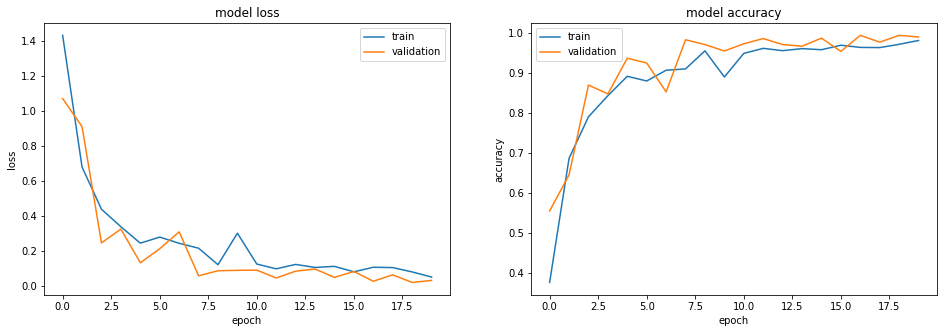

In [ ]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [ ]:
train_generator.class_indices

{'갈아만든배': 0,
 '레쓰비': 1,
 '마운틴듀': 2,
 '밀키스': 3,
 '스프라이트': 4,
 '칠성사이다': 5,
 '코카콜라': 6,
 '트로피카나망고': 7,
 '펩시콜라': 8,
 '환타오렌지': 9}

In [ ]:
test_img = cv2.imread('./2205722_1.jpg')  # 펩시콜라 : 8
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(224,224))/255.0
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[0.0000000e+00, 3.2855604e-11, 0.0000000e+00, 8.1943983e-15,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 1.8053230e-24]], dtype=float32)

In [ ]:
test_img = cv2.imread('./11.jpg')  # 환타오렌지 : 9
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(224,224))/255.0
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[2.29299847e-12, 1.07922435e-26, 2.43103697e-36, 1.48838569e-33,
        1.83888911e-37, 0.00000000e+00, 3.17779444e-18, 1.14305639e-14,
        1.11835422e-23, 1.00000000e+00]], dtype=float32)